# YOLOv1 Inference

In this notebook you will see how use an already trained YOLOv1 model  for inference.

## Preparation

Download the code and fix few bugs there.

In [1]:
!git clone https://github.com/motokimura/yolo_v1_pytorch.git

!sed -i '117s/.*/            pred_xyxy[:,  :2] = pred[:, :2]\/float(S) - 0.5 * pred[:, 2:4]/' yolo_v1_pytorch/loss.py
!sed -i '118s/.*/            pred_xyxy[:, 2:4] = pred[:, :2]\/float(S) + 0.5 * pred[:, 2:4]/' yolo_v1_pytorch/loss.py
!sed -i '125s/.*/            target_xyxy[:,  :2] = target[:, :2]\/float(S) - 0.5 * target[:, 2:4]/' yolo_v1_pytorch/loss.py
!sed -i '126s/.*/            target_xyxy[:, 2:4] = target[:, :2]\/float(S) + 0.5 * target[:, 2:4]/' yolo_v1_pytorch/loss.py

Cloning into 'yolo_v1_pytorch'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 204 (delta 1), reused 0 (delta 0), pack-reused 197
Receiving objects: 100% (204/204), 2.92 MiB | 1.52 MiB/s, done.
Resolving deltas: 100% (99/99), done.


Install tool to download files from Google Drive

In [2]:
!pip install googledrivedownloader

Download pre-trained model weights from Google Drive

In [3]:
from google_drive_downloader import GoogleDriveDownloader as gdd
#1 Gig of training related stuff
gdd.download_file_from_google_drive(file_id='13RtD4hPnjTVqUpVyKCAZ7vbMXPbN4T3E',
                                    dest_path='./models/model_best.pth', 
                                    showsize=True, 
                                    overwrite=True)

1.0 GiB Done.


Append YOLOv1 code to the $PATH such that Python can access it

In [4]:
import sys
sys.path.append("yolo_v1_pytorch")

Import libs

In [5]:
import numpy as np

import cv2
import matplotlib.pyplot as plt

from detect import YOLODetector, VOC_CLASS_BGR

Utility to visualize bboxes

In [6]:
def visualize_boxes(image_bgr, boxes, class_names, probs, name_bgr_dict=None):
    line_thickness = int(2. / 600. * max(image_bgr.shape))
    if name_bgr_dict is None:
        name_bgr_dict = VOC_CLASS_BGR

    image_boxes = image_bgr.copy()
    for box, class_name, prob in zip(boxes, class_names, probs):
        # Draw box on the image.
        left_top, right_bottom = box
        left, top = int(left_top[0]), int(left_top[1])
        right, bottom = int(right_bottom[0]), int(right_bottom[1])
        bgr = name_bgr_dict[class_name]
        cv2.rectangle(image_boxes, (left, top), (right, bottom), bgr, thickness=line_thickness)

        # Draw text on the image.
        text = '%s %.2f' % (class_name, prob)
        size, baseline = cv2.getTextSize(text,  cv2.FONT_HERSHEY_SIMPLEX, 
                                         fontScale=0.5 / 600 * max(image_bgr.shape), thickness=2)
        text_w, text_h = size

        x, y = left, top
        x1y1 = (x, y)
        x2y2 = (x + text_w + line_thickness, y + text_h + line_thickness + baseline)
        cv2.rectangle(image_boxes, x1y1, x2y2, bgr, -1)
        cv2.putText(image_boxes, text, (x + line_thickness, y + 2*baseline + line_thickness),
            cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4 / 600 * max(image_bgr.shape), 
            color=(255, 255, 255), 
            thickness=int(1.0 / 600 * max(image_bgr.shape)), 
            lineType=8)

    return image_boxes

## Load model

Path to the YOLOv1 model weights

In [8]:
ls -l ./models

total 1061516
-rw-r--r-- 1 root root 1086988146 Aug 26 12:32 model_best.pth


In [7]:
model_path = './models/model_best.pth'

GPU device on which the model is loaded

In [9]:
gpu_id = 0

Load model

In [10]:
yolo_pred = YOLODetector(model_path, gpu_id=gpu_id, conf_thresh=0.75, prob_thresh=0.15, nms_thresh=0.35)

Loading YOLO model...
Done loading!


## Inference

Download test image

In [11]:
!wget https://blog.mystart.com/wp-content/uploads/shutterstock_224423782-1-e1527774744419.jpg -O test.jpg

--2020-08-26 12:34:39--  https://blog.mystart.com/wp-content/uploads/shutterstock_224423782-1-e1527774744419.jpg
Resolving blog.mystart.com (blog.mystart.com)... 52.200.67.34
Connecting to blog.mystart.com (blog.mystart.com)|52.200.67.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203522 (199K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 198.75K   585KB/s    in 0.3s    

2020-08-26 12:34:40 (585 KB/s) - ‘test.jpg’ saved [203522/203522]



Read image, make predictions and visualize them

yolo_v1_pytorch/detect.py:278: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  ids_keep = (ious <= threshold).nonzero().squeeze() # [m-1, ]. Because `nonzero()` adds extra dimension, squeeze it.


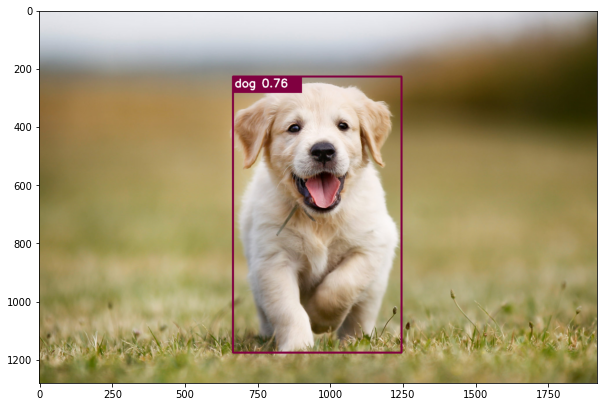

In [12]:
image_path = "test.jpg"
image = cv2.imread(image_path)
boxes, class_names, probs = yolo_pred.detect(image)
plt.figure(figsize=(10, 10))
plt.imshow(visualize_boxes(image, boxes, class_names, probs)[..., ::-1])

## Raw predictions

Previously the predictions were decoded from the YOLOv1 output format to be able to visualize them. Now let's look at the raw prediction volume.

First of all, let's read the test image and resize it down to necessary input size.

In [14]:
import torch
import torchvision

In [17]:
mean = np.array([122.67891434, 116.66876762, 104.00698793], dtype="float32")
image_path = "test.jpg"
image = cv2.imread(image_path)
h, w, _ = image.shape
print(f"Image original shape {image.shape}")
img = cv2.resize(image, dsize=(448, 448), interpolation=cv2.INTER_LINEAR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # assuming the model is trained with RGB images.
img = (img - mean) / 255.0 #center the image and normalize
img = torchvision.transforms.ToTensor()(img) # [image_size, image_size, 3] -> [3, image_size, image_size]
img = img[None, :, :, :]  # [3, image_size, image_size] -> [1, 3, image_size, image_size]
img = img.cuda()
print(f"Image: transformed shape {img.shape}")

Image original shape (1280, 1920, 3)
Image: transformed shape torch.Size([1, 3, 448, 448])


In [18]:
with torch.no_grad():
    pred_tensor = yolo_pred.yolo(img)
pred_tensor = pred_tensor.cpu().numpy()
pred_tensor = pred_tensor.squeeze(0) # squeeze batch dimension.

In [19]:
pred_tensor.shape

(7, 7, 30)

Filter bbox based on predicted confidences. Recall:

`conf_thresh=0.75, prob_thresh=0.15, nms_thresh=0.35`

In [20]:
pred_tensor[:, :, 4] > 0.75. #Bounding box1 confidence

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

Second bbox predictor confidences

In [22]:
pred_tensor[:, :, 4 + 5] > 0.75 # Bounding box2 confidence

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False,  True, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

Both predictor confidences are higher than the threshold at cell $(3, 3)$. In this case we select the one with highest objectivness score

In [23]:
print(f"First predictor score: {pred_tensor[3, 3, 4]:.3f}")
print(f"Second predictor score: {pred_tensor[3, 3, 4 + 5]:.3f}")

First predictor score: 0.757
Second predictor score: 0.803


Second predictor has higher score thus we choose the bbox from the second predictor in this cell.

Now we need to decode the predictions 

In [24]:
pred_tensor[3, 3, 5:9]   #BBox coords

array([0.49020627, 0.8327042 , 0.30206424, 0.74237657], dtype=float32)

First, let's calculate the cell width and height in terms of the original image size

In [25]:
# Image original shape (1280, 1920, 3)
# Image: transformed shape torch.Size([1, 3, 448, 448])

cell_w, cell_h = image.shape[1] / 7, image.shape[0] / 7
print(cell_w, cell_h)

274.2857142857143 182.85714285714286


Then let's recall that YOLOv1 predicts the center of the object relatively to the cell and normalized from 0 to 1.

Using this information we can decode the center position in absolute coordinates:

In [26]:
x_center = cell_w * (3 + pred_tensor[3, 3, 5])
y_center = cell_h * (3 + pred_tensor[3, 3, 6])
print(x_center, y_center)

957.3137201581682 700.8373369489398


The width and height are predicted directly normalized for image total width and height

In [27]:
w = pred_tensor[3, 3, 7] * image.shape[1] #Bbox 2's width prediction
h = pred_tensor[3, 3, 8] * image.shape[0]
print(w, h)

579.9633407592773 950.2420043945312


The last step is to computer coordinates of top-left corner and bottom-right corner instead of center and width/height.

In [28]:
x_min = x_center - 0.5 * w
y_min = y_center - 0.5 * h
x_max = x_center + 0.5 * w
y_max = y_center + 0.5 * h
print((x_min, y_min), (x_max, y_max))

(667.3320497785295, 225.71633475167414) (1247.2953905378067, 1175.9583391462054)


The box decoded automatically is:

In [29]:
boxes #predicted and unpacked from above

[((tensor(667.3321), tensor(225.7164)),
  (tensor(1247.2954), tensor(1175.9584)))]

One can notice that they are identical

Finally, let's decode class probability vector

In [30]:
print(pred_tensor[3, 3, 10:].shape)
pred_tensor[3, 3, 10:]

(20,)


array([1.1892070e-03, 4.7750527e-04, 5.5317795e-03, 3.2794522e-04,
       5.2428315e-03, 1.2162083e-03, 7.0939795e-03, 4.6833069e-03,
       1.6174356e-02, 1.6381344e-02, 1.4038527e-03, 9.4258332e-01,
       1.5755766e-03, 4.9845730e-03, 6.4970613e-02, 7.9736265e-04,
       1.1845003e-02, 1.0355590e-02, 7.2746433e-04, 1.8140734e-03],
      dtype=float32)

One just needs to choose the class with the highest probability

In [33]:
print(np.max(pred_tensor[3, 3, 10:]))
class_id = np.argmax(pred_tensor[3, 3, 10:])
class_id

0.9425833


11

Let's get a human-readable class name and its probability

In [32]:
voc_class_names = [
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor'
]

To get the probability we need to multiply the predicted conditional probability by the objectness score of the selected bbox.

It is done like that in the [original implementation](https://github.com/pjreddie/darknet/blob/bc5ea7cca8c770ebdacd2c792ddd96f6904ee23a/src/detection_layer.c#L247)

In [34]:
print("Class:", voc_class_names[class_id])
print(f"Proba: {pred_tensor[3, 3, 10:][class_id]} * {pred_tensor[3, 3, 4 + 5]}")
print("Proba:", pred_tensor[3, 3, 10:][class_id] * pred_tensor[3, 3, 4 + 5])

Class: dog
Proba: 0.9425833225250244 * 0.8025035262107849
Proba: 0.75642645


Now we can see that the class and the probability also match what we've seen from the automatic decoding provided by the library.